# Low-Pass Filter

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [2]:
# download modsim.py if necessary

from os.path import exists

filename = 'modsim.py'
if not exists(filename):
    from urllib.request import urlretrieve
    url = 'https://raw.githubusercontent.com/AllenDowney/ModSim/main/'
    local, _ = urlretrieve(url+filename, filename)
    print('Downloaded ' + local)

In [3]:
# import functions from modsim

from modsim import *

The following circuit diagram (from [Wikipedia](https://en.wikipedia.org/wiki/File:RC_Divider.svg)) shows a low-pass filter built with one resistor and one capacitor.  

![Circuit diagram of a low-pass filter](https://github.com/AllenDowney/ModSim/raw/main/figs/RC_Divider.svg)

A "filter" is a circuit takes a signal, $V_{in}$, as input and produces a signal, $V_{out}$, as output.  In this context, a "signal" is a voltage that changes over time.

A filter is "low-pass" if it allows low-frequency signals to pass from $V_{in}$ to $V_{out}$ unchanged, but it reduces the amplitude of high-frequency signals.

By applying the laws of circuit analysis, we can derive a differential equation that describes the behavior of this system.  By solving the differential equation, we can predict the effect of this circuit on any input signal.

Suppose we are given $V_{in}$ and $V_{out}$ at a particular instant in time.  By Ohm's law, which is a simple model of the behavior of resistors, the instantaneous current through the resistor is:

$ I_R = (V_{in} - V_{out}) / R $

where $R$ is resistance in ohms.

Assuming that no current flows through the output of the circuit, Kirchhoff's current law implies that the current through the capacitor is:

$ I_C = I_R $

According to a simple model of the behavior of capacitors, current through the capacitor causes a change in the voltage across the capacitor:

$ I_C = C \frac{d V_{out}}{dt} $

where $C$ is capacitance in farads (F).

Combining these equations yields a differential equation for $V_{out}$:

$ \frac{d }{dt} V_{out} = \frac{V_{in} - V_{out}}{R C} $

Follow the instructions below to simulate the low-pass filter for input signals like this:

$ V_{in}(t) = A \cos (2 \pi f t) $

where $A$ is the amplitude of the input signal, say 5 V, and $f$ is the frequency of the signal in Hz.

## Params and System objects

Here's a `Params` object to contain the quantities we need.  I've chosen values for `R1` and `C1` that might be typical for a circuit that works with audio signal.

In [4]:
params = Params(
    R1 = 1e6,   # * ohm
    C1 = 1e-9,  # * farad
    A = 5,      # * volt
    f = 1000,   # * Hz
)
params

namespace(R1=1000000.0, C1=1e-09, A=5, f=1000)

Now we can pass the `Params` object `make_system` which computes some additional parameters and defines `init`.

* `omega` is the frequency of the input signal in radians/second.

* `tau` is the time constant for this circuit, which is the time it takes to get from an initial startup phase to 

* `cutoff` is the cutoff frequency for this circuit (in Hz), which marks the transition from low frequency signals, which pass through the filter unchanged, to high frequency signals, which are attenuated.

* `t_end` is chosen so we run the simulation for 4 cycles of the input signal.

In [5]:
from numpy import pi

def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    f, R1, C1 = params.f, params.R1, params.C1
    
    init = State(V_out = 0)
    omega = 2 * pi * f
    tau = R1 * C1
    cutoff = 1 / R1 / C1 / 2 / pi
    t_end = 4 / f
    
    return System(params, 
                  init=init, 
                  t_end=t_end, num=1000,
                  omega=omega, tau=tau, 
                  cutoff=cutoff)

Let's make a `System`

In [6]:
system = make_system(params)
system

namespace(R1=1000000.0,
          C1=1e-09,
          A=5,
          f=1000,
          init=V_out    0
               Name: state, dtype: int64,
          t_end=0.004,
          num=1000,
          omega=6283.185307179586,
          tau=0.001,
          cutoff=159.15494309189532)

**Exercise:** Write a slope function that takes as an input a `State` object that contains `V_out`, and returns the derivative of `V_out`.


In [7]:
# Solution

def slope_func(t, state, system):
    """Compute derivatives of the state.
    
    t: time
    state: V_out
    system: System object with A, omega, R1 and C1
    
    returns: dV_out/dt
    """
    V_out = state
    
    R1, C1 = system.R1, system.C1
    A, omega = system.A, system.omega
    
    V_in = A * np.cos(omega * t)
    
    V_R1 = V_in - V_out

    I_R1 = V_R1 / R1
    I_C1 = I_R1

    dV_out_dt = I_C1 / C1

    return dV_out_dt

Test the slope function with the initial conditions.

In [8]:
slope_func(0, system.init, system)

V_out    5000.0
Name: state, dtype: float64

And then run the simulation.  I suggest using `t_eval=ts` to make sure we have enough data points to plot and analyze the results. 

In [9]:
results, details = run_solve_ivp(system, slope_func)
details.message

'The solver successfully reached the end of the integration interval.'

In [10]:
results.tail()

,V_out
0.003984,0.042631
0.003988,0.062367
0.003992,0.082062
0.003996,0.101702
0.004000,0.121274


Here's a function you can use to plot `V_out` as a function of time.

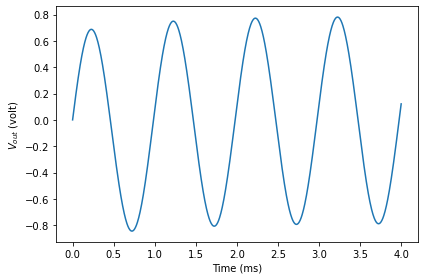

In [11]:
def plot_results(results):
    V_out = results.V_out.copy()
    t_end = results.index[-1]
    
    if t_end < 0.1:
        V_out.index *= 1000
        xlabel = 'Time (ms)'
    else:
        V_out = results.V_out
        xlabel = 'Time (s)'
        
    V_out.plot(label='_nolegend')
    decorate(xlabel=xlabel,
             ylabel='$V_{out}$ (volt)')
    
plot_results(results)

If things have gone according to plan, the amplitude of the output signal should be about 0.8 V.

Also, you might notice that it takes a few cycles for the signal to get to the full amplitude. 

## Sweeping frequency

Here's what `V_out` looks like for a range of frequencies:

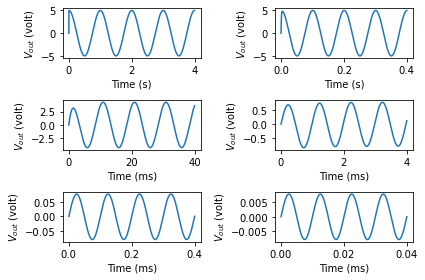

In [12]:
from matplotlib.pyplot import subplot

fs = [1, 10, 100, 1000, 10000, 100000]

for i, f in enumerate(fs):
    system = make_system(params.set(f=f))
    results, details = run_solve_ivp(system, slope_func)
    subplot(3, 2, i+1)
    plot_results(results)

At low frequencies, notice that there is an initial "transient" before the output gets to a steady-state sinusoidal output.  The duration of this transient is a small multiple of the time constant, `tau`, which is 1 ms.

## Estimating the output ratio

Let's compare the amplitudes of the input and output signals.  Below the cutoff frequency, we expect them to be about the same.  Above the cutoff, we expect the amplitude of the output signal to be smaller.

We'll start with a signal at the cutoff frequency, `f=1000` Hz.

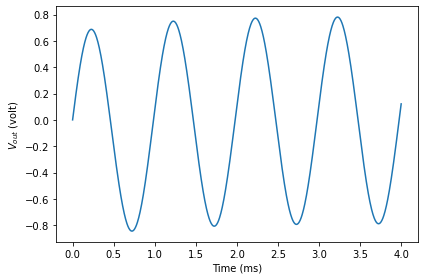

In [13]:
system = make_system(params.set(f=1000))
results, details = run_solve_ivp(system, slope_func)
V_out = results.V_out
plot_results(results)

The following function computes `V_in` as a `TimeSeries`:

In [14]:
def compute_vin(results, system):
    """Computes V_in as a TimeSeries.
    
    results: TimeFrame with simulation results
    system: System object with A and omega
    
    returns: TimeSeries
    """
    A, omega = system.A, system.omega
    
    ts = results.index
    V_in = A * np.cos(omega * ts)
    return TimeSeries(V_in, results.index, name='V_in')

Here's what the input and output look like.  Notice that the output is not just smaller; it is also "out of phase"; that is, the peaks of the output are shifted to the right, relative to the peaks of the input.

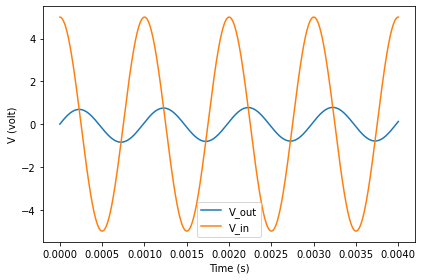

In [15]:
V_in = compute_vin(results, system)

V_out.plot()
V_in.plot()

decorate(xlabel='Time (s)',
         ylabel='V (volt)')

The following function estimates the amplitude of a signal by computing half the distance between the min and max.

In [16]:
def estimate_A(series):
    """Estimate amplitude.
    
    series: TimeSeries
    
    returns: amplitude in volts
    """
    return (series.max() - series.min()) / 2

The amplitude of `V_in` should be near 5 (but not exact because we evaluated it at a finite number of points).

In [17]:
A_in = estimate_A(V_in)
A_in

4.999987638293614

The amplitude of `V_out` should be lower.

In [18]:
A_out = estimate_A(V_out)
A_out

0.8128429729546041

And here's the ratio between them.

In [19]:
ratio = A_out / A_in
ratio

0.16256899651696127

**Exercise:** Encapsulate the code we have so far in a function that takes two `TimeSeries` objects and returns the ratio between their amplitudes.

In [20]:
# Solution

def estimate_ratio(V1, V2):
    """Estimate the ratio of amplitudes.
    
    V1: TimeSeries
    V2: TimeSeries
    
    returns: amplitude ratio
    """
    a1 = estimate_A(V1)
    a2 = estimate_A(V2)
    return a1 / a2

And test your function.

In [21]:
estimate_ratio(V_out, V_in)

0.16256899651696127

## Estimating phase offset

The delay between the peak of the input and the peak of the output is call a "phase shift" or "phase offset", usually measured in fractions of a cycle, degrees, or radians.

To estimate the phase offset between two signals, we can use cross-correlation.  Here's what the cross-correlation looks like between `V_out` and `V_in`:

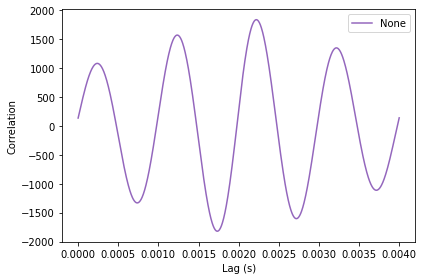

In [22]:
corr = np.correlate(V_out, V_in, mode='same')
corr_series = make_series(V_in.index, corr)
corr_series.plot(color='C4')
decorate(xlabel='Lag (s)',
         ylabel='Correlation')

The location of the peak in the cross correlation is the estimated shift between the two signals, in seconds.

In [23]:
peak_time = corr_series.idxmax()
peak_time

0.002218218218218218

We can express the phase offset as a multiple of the period of the input signal:

In [24]:
period = 1 / system.f
period

0.001

In [25]:
peak_time / period

2.218218218218218

We don't care about whole period offsets, only the fractional part, which we can get using `modf`:

In [26]:
frac, whole = np.modf(peak_time / period)
frac

0.21821821821821796

Finally, we can convert from a fraction of a cycle to degrees:

In [27]:
frac * 360

78.55855855855847

**Exercise:** Encapsulate this code in a function that takes two `TimeSeries` objects and a `System` object, and returns the phase offset in degrees.

Note: by convention, if the output is shifted to the right, the phase offset is negative.

In [28]:
# Solution

def estimate_offset(V1, V2, system):
    """Estimate phase offset.
    
    V1: TimeSeries
    V2: TimeSeries
    system: System object with f
    
    returns: amplitude ratio
    """
    corr = np.correlate(V1, V2, mode='same')
    corr_series = make_series(V1.index, corr)
    peak_time = corr_series.idxmax()
    period = 1 / system.f
    frac, whole = np.modf(peak_time / period)
    return -frac * 360

Test your function.

In [29]:
estimate_offset(V_out, V_in, system)

-78.55855855855847

## Sweeping frequency again

**Exercise:** Write a function that takes as parameters an array of input frequencies and a `Params` object.

For each input frequency it should run a simulation and use the results to estimate the output ratio (dimensionless) and phase offset (in degrees).

It should return two `SweepSeries` objects, one for the ratios and one for the offsets.

In [30]:
# Solution

def sweep_frequency(fs, params):
    ratios = SweepSeries()
    offsets = SweepSeries()

    for i, f in enumerate(fs):
        system = make_system(params.set(f=f))
        results, details = run_solve_ivp(system, slope_func)
        V_out = results.V_out
        V_in = compute_vin(results, system)
        
        f = magnitude(f)
        ratios[f] = estimate_ratio(V_out, V_in)
        offsets[f] = estimate_offset(V_out, V_in, system)
    return ratios, offsets

Run your function with these frequencies.

In [31]:
fs = 10 ** linspace(0, 4, 9)

In [32]:
ratios, offsets = sweep_frequency(fs, params)

We can plot output ratios like this:

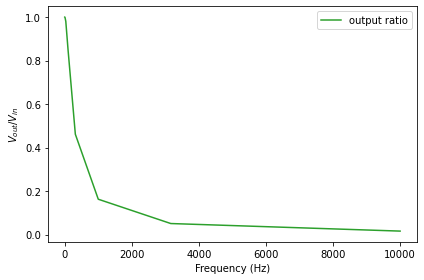

In [33]:
ratios.plot(color='C2', label='output ratio')
decorate(xlabel='Frequency (Hz)',
         ylabel='$V_{out} / V_{in}$')

But it is useful and conventional to plot ratios on a log-log scale.  The vertical gray line shows the cutoff frequency.

In [34]:
def plot_ratios(ratios, system):
    """Plot output ratios.
    """
    # axvline can't handle a Quantity with units
    cutoff = magnitude(system.cutoff)
    plt.axvline(cutoff, color='gray', alpha=0.4)
    
    ratios.plot(color='C2', label='output ratio')
    decorate(xlabel='Frequency (Hz)',
             ylabel='$V_{out} / V_{in}$',
             xscale='log', yscale='log')

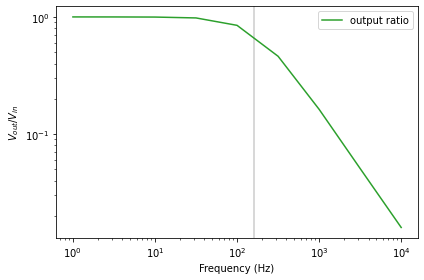

In [35]:
plot_ratios(ratios, system)

This plot shows the cutoff behavior more clearly.  Below the cutoff, the output ratio is close to 1.  Above the cutoff, it drops off linearly, on a log scale, which indicates that output ratios for high frequencies are practically 0.

Here's the plot for phase offset, on a log-x scale:

In [36]:
def plot_offsets(offsets, system):
    """Plot phase offsets.
    """
    # axvline can't handle a Quantity with units
    cutoff = magnitude(system.cutoff)
    plt.axvline(cutoff, color='gray', alpha=0.4)
    
    offsets.plot(color='C9')
    decorate(xlabel='Frequency (Hz)',
             ylabel='Phase offset (degree)',
             xscale='log')

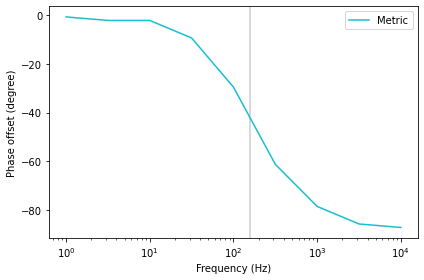

In [37]:
plot_offsets(offsets, system)

For low frequencies, the phase offset is near 0.  For high frequencies, it approaches 90 degrees.

### Analysis

By analysis we can show that the output ratio for this signal is

$A = \frac{1}{\sqrt{1 + (R C \omega)^2}}$ 

where $\omega = 2 \pi f$, and the phase offset is

$ \phi = \arctan (- R C \omega)$ 

**Exercise:** Write functions that take an array of input frequencies and returns $A(f)$ and $\phi(f)$ as `SweepSeries` objects.  Plot these objects and compare them with the results from the previous section.


In [38]:
# Solution

fs = 10 ** linspace(0, 4, 9)

def output_ratios(fs, system):
    R1, C1, omega = system.R1, system.C1, system.omega
    
    omegas = 2 * pi * fs
    rco = R1 * C1 * omegas
    A = 1 / np.sqrt(1 + rco**2)
    return make_series(fs, A)

Test your function:

In [39]:
A = output_ratios(fs, system)

In [40]:
# Solution

def phase_offsets(fs, system):
    R1, C1, omega = system.R1, system.C1, system.omega

    omegas = 2 * pi * fs
    rco = R1 * C1 * omegas
    phi = np.rad2deg(np.arctan(-rco))
    return make_series(fs, phi)

Test your function:

In [41]:
phi = phase_offsets(fs, system)

Plot the theoretical results along with the simulation results and see if they agree.

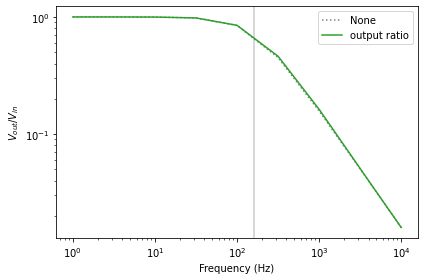

In [42]:
A.plot(style=':', color='gray')
plot_ratios(ratios, system)

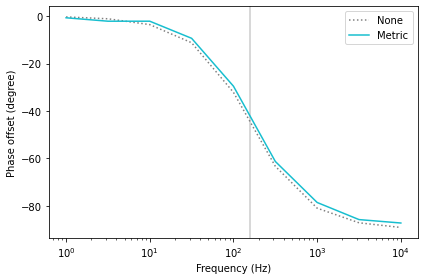

In [43]:
phi.plot(style=':', color='gray')
plot_offsets(offsets, system)

For the phase offsets, there are differences between the theoretical results and our estimates, but that is probably because it is not easy to estimate phase offsets precisely from numerical results.

**Exercise:** Consider modifying this notebook to model a [first order high-pass filter](https://en.wikipedia.org/wiki/High-pass_filter#First-order_continuous-time_implementation), a [two-stage second-order low-pass filter](https://www.electronics-tutorials.ws/filter/filter_2.html), or a [passive band-pass filter](https://www.electronics-tutorials.ws/filter/filter_4.html).